In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from pyLIMA.outputs import pyLIMA_plots
from cycler import cycler

sys.path.append(os.path.dirname(os.getcwd()))
from functions_roman_rubin import sim_fit
from functions_roman_rubin import model_rubin_roman
from functions_roman_rubin import read_data

current_path = os.path.dirname(os.getcwd())
# print(current_path)
i=18
model='USBL'
algo='TRF'
path_TRILEGAL_set= current_path+'/TRILEGAL/PB_planet_split_1.csv'
path_to_save_model= current_path+'/test_sim_fit/'
path_to_save_fit= current_path+'/test_sim_fit/'
path_ephemerides= current_path+'/ephemerides/Gaia.txt'
path_dataslice = current_path+'/opsims/baseline/dataSlice.npy'
path_fit_rr = path_to_save_fit+f'/Event_RR_{i}_TRF.npy'
path_fit_roman =  path_to_save_fit+f'/Event_Roman_{i}_TRF.npy'
ZP = {'W149':27.615, 'u':27.03, 'g':28.38, 'r':28.16,
          'i':27.85, 'z':27.46, 'y':26.68}
colorbands={'W149':'b', 'u':'purple', 'g':'g', 'r':'red',
          'i':'yellow', 'z':'k', 'y':'cyan'}

/home/anibal/roman_rubin


In [2]:
# os.listdir(path_to_save_model)

In [3]:
try:
    info_dataset, pyLIMA_parameters, bands = read_data(path_to_save_model+'/Event_18.h5')
    data_fit_rr = np.load(path_fit_rr,allow_pickle=True).item()
    data_fit_roman = np.load(path_fit_roman,allow_pickle=True).item()
except:    
    sim_fit(i,model,algo,path_TRILEGAL_set,path_to_save_model,path_to_save_fit,path_ephemerides,path_dataslice)
    info_dataset, pyLIMA_parameters, bands = read_data(path_to_save_model+'/Event_18.h5')
    data_fit_rr = np.load(path_fit_rr,allow_pickle=True).item()
    data_fit_roman = np.load(path_fit_roman,allow_pickle=True).item()

In [4]:
# print(data_fit_rr['best_model'])
# print(data_fit_roman['best_model'])
# print(pyLIMA_parameters)
ulens_params = []
PAR = ['t_center','u_center','tE','rho','separation','mass_ratio','alpha','piEN','piEE']
# PAR = ['t0','u0','tE','piEN','piEE']
for b in (PAR):
    ulens_params.append(pyLIMA_parameters[b])
flux_params = []
for b in bands:
    if not len(bands[b])==0:
        zp_Rubin_to_pyLIMA = (10**((-27.4+ZP[b])/2.5))
        
        flux_params.append(pyLIMA_parameters['fsource_'+b]/zp_Rubin_to_pyLIMA)
        flux_params.append(pyLIMA_parameters['ftotal_'+b]/zp_Rubin_to_pyLIMA)
        
true_params = ulens_params+flux_params

In [5]:
model_ulens = 'USBL'

Source = 18
event_params = pyLIMA_parameters
event_params['te']=event_params['tE']
event_params['s']=event_params['separation']
event_params['q']=event_params['mass_ratio']

f= 'W149'
wfirst_lc = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f = 'u'
lsst_u = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='g'
lsst_g = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='r'
lsst_r = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='i'
lsst_i = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_z = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T
f='z'
lsst_y = np.array([bands[f]['time'],bands[f]['mag'],bands[f]['err_mag']]).T

model_true = model_rubin_roman(Source,True,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)

# {'t_center':data_fit_rr['best_model'][0]}
model_rr = model_rubin_roman(Source,False,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
                    lsst_y)
# {'t_center':data_fit_roman['best_model'][0]}
model_roman = model_rubin_roman(Source,False,event_params, path_ephemerides,model_ulens, wfirst_lc, [], [], [], [], [],[])

# model1 = model_rubin_roman(Source,event_params, path_ephemerides,model_ulens, wfirst_lc, lsst_u, lsst_g, lsst_r, lsst_i, lsst_z,
#                     lsst_y)

check_event  : Everything looks fine...


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 20736 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 20736 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 1 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: Er

Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 96 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 86 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 86 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 86 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWa

Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS
Parallax(Full) estimated for the telescope r: SUCCESS
Parallax(Full) estimated for the telescope i: SUCCESS
Parallax(Full) estimated for the telescope z: SUCCESS
Parallax(Full) estimated for the telescope y: SUCCESS
check_event  : Everything looks fine...
Parallax(Full) estimated for the telescope Roman (Roman): SUCCESS


In [6]:
plt.close('all')
# custom_cycler = (cycler(color=custom_color))

# pyLIMA_plots.MARKERS_COLORS = custom_cycler
# pyLIMA_plots.MARKER_SYMBOLS = np.array([custom_marker])
### Find the telescope fluxes if needed

if len(data_fit_rr['best_model']) != len(model_rr.model_dictionnary):
    telescopes_fluxes = model_rr.find_telescopes_fluxes(data_fit_rr['best_model'])
    telescopes_fluxes = [telescopes_fluxes[key] for key in
                         telescopes_fluxes]#._fields]
    model_parameters1 = np.r_[data_fit_rr['best_model'], telescopes_fluxes]
else:
    model_parameters1 = data_fit_rr['best_model']

    
if len(data_fit_roman['best_model']) != len(model_roman.model_dictionnary):
    telescopes_fluxes = model_roman.find_telescopes_fluxes(data_fit_roman['best_model'])
    telescopes_fluxes = [telescopes_fluxes[key] for key in
                         telescopes_fluxes]#._fields]
    model_parameters2 = np.r_[data_fit_rr['best_model'], telescopes_fluxes]
else:
    model_parameters2 = data_fit_rr['best_model']
    
# if len(true_params) != len(model_true.model_dictionnary):
#     telescopes_fluxes = model_true.find_telescopes_fluxes(true_params)
#     telescopes_fluxes = [getattr(telescopes_fluxes, key) for key in
#                          telescopes_fluxes]#._fields]
#     model_parameters3 = np.r_[true_params, telescopes_fluxes]
# else:
#     model_parameters3 = true_params

/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 153108 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 153108 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 136830 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 136830 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 136830 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope g: SUCCESS


/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 191876 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/anibal/anaconda3/envs/pyLIMA_utd/lib/python3.11/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 191876 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


Parallax(Full) estimated for the telescope Roman (Roman): SUCCESS
Parallax(Full) estimated for the telescope Roman (Roman+Rubin): SUCCESS
Parallax(Full) estimated for the telescope g: SUCCESS


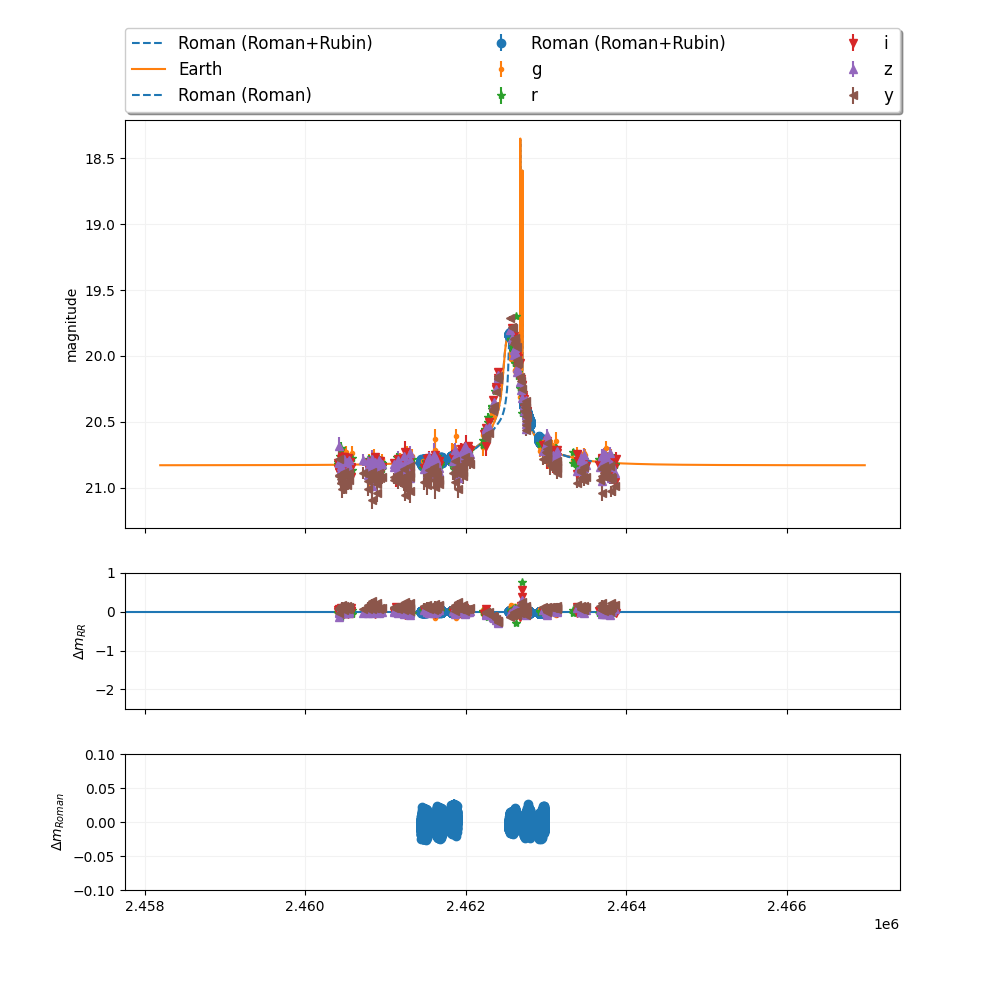

In [7]:
# tmin, tmax = 2460200., data_ogle[-1,0]+5.
# tmin, tmax = 2460160., data_ogle[-1,0]+20.

%matplotlib widget
fig, axes = plt.subplots(3, 1,figsize=(10,10), height_ratios=[3, 1,1], sharex=True)

# Lc plot
axes[0].title.set_text('name')
axes[0].set_ylabel("magnitude") 
axes[0].grid(True, color='0.95')
axes[0].invert_yaxis()
# axes[0].set_xlim(tmin, tmax)
# axes[0].set_ylim(18.5, 12.5) 
# axes[0].set_ylim(17.5, 12.5) 

#Plot model1 and align data to it
pyLIMA_plots.plot_photometric_models(axes[0], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_photometric_models(axes[0], model_roman, data_fit_roman['best_model'], plot_unit='Mag')
# pyLIMA_plots.plot_photometric_models(axes[0], model_true, true_params, plot_unit='Mag')
pyLIMA_plots.plot_aligned_data(axes[0], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
# model_parameters2
# model_parameters3
colors = ['darkslategray', 'gray', 'lightgray']

# for i in range(len(spec_jds)):
#     axes[0].axvline(x=spec_jds[i], label='Spec_'+str(i), ls='--', color=colors[i])

# plot residuals
axes[1].set_ylabel("$\Delta m_{RR} $") 
axes[1].grid(True, color='0.95')
axes[2].set_ylabel("$\Delta m_{Roman} $") 
axes[2].grid(True, color='0.95')

pyLIMA_plots.plot_residuals(axes[1], model_rr, data_fit_rr['best_model'], plot_unit='Mag')
pyLIMA_plots.plot_residuals(axes[2], model_roman, data_fit_roman['best_model'], plot_unit='Mag')
# axes[1].set_xlim(tmin, tmax)
axes[1].set_ylim(-2.5, 1)
axes[1].axhline(y=0)

# for i in range(len(spec_jds)):
#     axes[1].axvline(x=spec_jds[i], ls='--', color=colors[i])

axes[0].legend(shadow=True, fontsize='large',
                          bbox_to_anchor=(0, 1.02, 1, 0.2),
                          loc="lower left",
                          mode="expand", borderaxespad=0, ncol=3)
plt.show()
